In [2]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
import scipy
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [15]:
da = xr.open_dataset('/scratch2/STI/mdl-sti/James.Long/mswep/mswepdata/2020/2020226.03.nc')

In [16]:
da

<xarray.Dataset>
Dimensions:        (lon: 3600, lat: 1800, time: 1)
Coordinates:
  * lon            (lon) float32 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * time           (time) datetime64[ns] 2020-08-13T03:00:00
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes:
    history:  Created on 2021-12-27 20:31

In [18]:
da.precipitation.data[0]

array([[0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625],
       ...,
       [0.125 , 0.125 , 0.125 , ..., 0.0625, 0.0625, 0.0625],
       [0.125 , 0.125 , 0.125 , ..., 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, ..., 0.0625, 0.0625, 0.0625]],
      dtype=float32)

In [12]:
np.shape(da.precipitation.data)
to_inches = 0.0393701

In [28]:
# from Jim's code, values < 0.254 are non-precipitation events
precip = da.precipitation.data[0]
precip[precip < 0.254] = 0

{230.0: ([<matplotlib.lines.Line2D at 0x146a2e7dc8b0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x146a2e7dcb20>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x146a2e7dcdc0>],
  [Text(875000.0, -50000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x146a2e7dd060>],
  [Text(1965000.0, -50000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x146a2e7dd300>],
  [Text(3040000.0, -50000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x146a2e7dd5a0>],
  [Text(4130000.0, -50000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x146a2e7dd840>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x146a2e7ddae0>], [])}

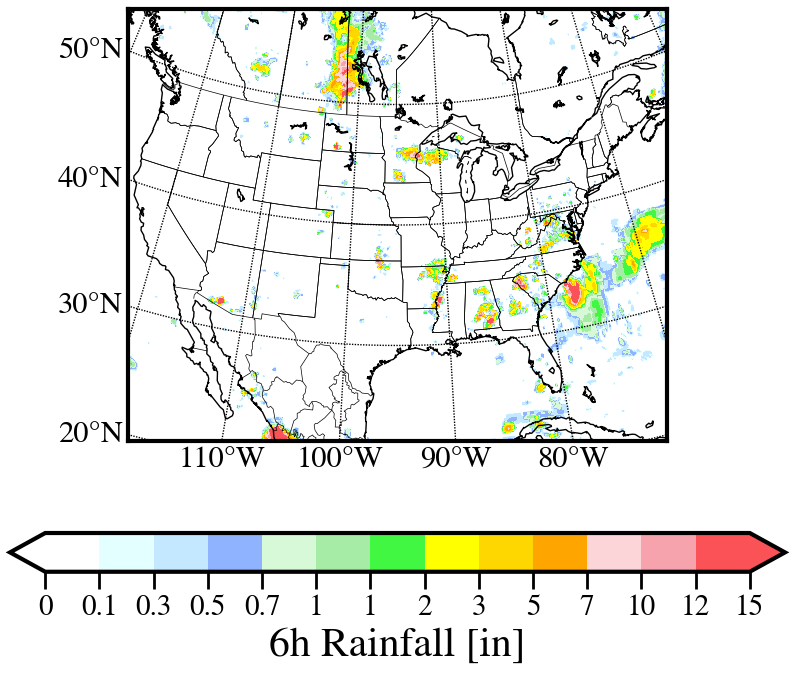

In [29]:
fig, axes = plt.subplots(1,1, figsize=(10,8))
clevs_precip = [0.0,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12.0,15.0,]

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 
#GEFS
lats, lons = da.lat.data, da.lon.data
gy, gx=np.meshgrid(lats,lons ,indexing='ij')
m = Basemap(projection='lcc',lon_0=-95,lat_0=40,width=5e6,height=4e6, resolution='l')
xx, yy = m(gx, gy) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,precip,extend='both',ax=axes,levels= clevs_precip,cmap=None,colors=colorst)
cbar=plt.colorbar(cs,orientation='horizontal', ticks=clevs_precip)
cbar.set_label('6h Rainfall [in]')
cbar.ax.set_xticklabels(['0']+[f'{int(x)}' if x >= 1 else f'{x}' for x in clevs_precip[1:]], fontsize=21)

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [22]:
len(lats) * len(lons)

6480000

## supplemental locations: domain specific params

In [1]:
precip_co_const = '/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc'

In [3]:
ds = xr.open_dataset(precip_co_const)

In [4]:
ds

<xarray.Dataset>
Dimensions:               (ya: 1597, xa: 2345, ngds_grib2: 200,
                           smooth_radius: 5, ngds_tdlpack: 12)
Coordinates:
    latitude              (ya, xa) float32 ...
    longitude             (ya, xa) float32 ...
  * smooth_radius         (smooth_radius) int32 1 5 10 20 40
  * xa                    (xa) float32 0.0 2.54e+03 ... 5.951e+06 5.953e+06
  * ya                    (ya) float32 0.0 2.54e+03 ... 4.051e+06 4.053e+06
Dimensions without coordinates: ngds_grib2, ngds_tdlpack
Data variables: (12/15)
    analysis_source_mask  (ya, xa) float32 ...
    conuslandmask         (ya, xa) float32 ...
    greatlakes_mask       (ya, xa) float32 ...
    grib2_gds             (ngds_grib2) int32 ...
    land_proximity        (ya, xa) float32 ...
    landmask              (ya, xa) float32 ...
    ...                    ...
    terrain_facets        (smooth_radius, ya, xa) float32 ...
    terrain_smoothed      (smooth_radius, ya, xa) float32 ...
    validmask             (ya, xa) float32 ...
    validmask_capa        (ya, xa) int16 ...
    validmask_ccpa        (ya, xa) int16 ...
    validmask_cmorph      (ya, xa) int16 ...
Attributes:
    title:        Masks and Terrain for Blend Precip Quantile Mapping
    Conventions:  CF-1.6
    institution:  ESRL/PSD NWS/MDL
    domain:       co

## what climo gamma params exist?

In [5]:
ds = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/climo/blend.t06z.Sep_precip06_climo_gamma_compstats.co.2p5.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:      (ya: 1597, xa: 2345)
Coordinates:
    latitude     (ya, xa) float32 ...
    longitude    (ya, xa) float32 ...
Dimensions without coordinates: ya, xa
Data variables:
    sums         (ya, xa) float32 ...
    sums_natlog  (ya, xa) float32 ...
    npositive    (ya, xa) float32 ...
    nzero        (ya, xa) float32 ...
Attributes:
    Title:        Monthly Climatological Gamma Distribution Parameters for NB...
    domain:       co
    source:       CCPA MSWEP
    version:      v4.1
    month:        Sep
    variable:     precip06
    ending_hour:  6

Ok so files containing relevant gamma params fit to the climo CDFs exist, appearing to be fit to CDFs constructed from both CCPA and MSWEP data --> unclear what year ranges, however. 

Eric mentioned wanting to maybe revamp the gamma params fitting script, using numba?

## towards a numba way of evaluating gamma distributions

need to evaluate alpha (shape), beta (scale), and fraction zero params

alpha is function of ln(<x\>) and <ln(x)>, with <x\> for x>0


1. for a given month+bookends, read in 3 hourly MSWEP data.

Then, EITHER

2. at each grid point, sum precip values for all 3 hourly files --> this could be an IO nightmare? perhaps open each serially instead of mf_dataset?
    - check for small values (e.g., precip < .254 mm) & set to 0
    - record # of precip >0 days and precip = 0 days

OR

3.  open bookended months, sum along time dimension, query precip > 0, =0 --> natural log sum/N>0, av natural log >0
4. compute D statistic --> alpha, beta, fraction 0

need to have prep area to cleanly gather correct months/days, since everything in julien day. since we only care about sums i don't think we need to keep track of days after that?